In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset with all merged features

In [2]:
all_properties = pd.read_csv("../data/curated/houses_all_properties.csv")
all_properties.head()

,address,parking,type,num_schools,cost,suburb,beds,baths,cost/(beds+baths),geometry,...,NUMBER_OF_JOBS_PERSONS_2018-19,NUMBER_OF_JOBS_PERSONS_2019-20,NUMBER_OF_JOBS_PERSONS_2020-21,MEDIAN_INCOME_PERSONS_2016-17,MEDIAN_INCOME_PERSONS_2017-18,MEDIAN_INCOME_PERSONS_2018-19,MEDIAN_INCOME_PERSONS_2019-20,MEDIAN_INCOME_PERSONS_2020-21,centroid,distance_to_centroid
0,"(Leased) 3 Yarra Street, South Yarra VIC 3141",1,Apartment / Unit / Flat,13,460.0,South Yarra,1,1,230.00,POINT (144.992828 -37.838173),...,13060.0,12759.0,12394.0,26306.5,27750.5,29043.5,32390.5,34577.5,POINT (144.9965000772275 -37.83614617221807),0.004194
1,"004B/12 Albert Street, Hawthorn East VIC 3123",0,Apartment / Unit / Flat,14,400.0,Hawthorn East,1,1,200.00,POINT (145.048408 -37.823472),...,15422.0,14730.0,14159.0,26100.5,27117.0,26803.5,31088.0,34211.0,POINT (145.04991149745675 -37.83126983822268),0.007941
2,"04/949 Dandenong Road, Malvern East VIC 3145",0,Apartment / Unit / Flat,10,365.0,Malvern East,1,1,182.50,POINT (145.048262 -37.878631),...,18950.0,18895.0,19034.0,25636.0,26307.0,25956.5,28608.0,30642.5,POINT (145.065853863916 -37.87682309041124),0.017685
3,"0711/333 Exhibition St, Melbourne VIC 3000",0,Apartment / Unit / Flat,12,675.0,Melbourne,2,2,168.75,POINT (144.96834 -37.807831),...,13693.0,12473.0,11002.0,10656.0,10929.0,11120.5,12060.0,14478.0,POINT (144.96859287539095 -37.812787018836396),0.004962
4,"1 & 2/23 Koonawarra Street, Clayton VIC 3168",1,House,5,340.0,Clayton,1,1,170.00,POINT (145.124589 -37.90863),...,6188.0,6445.0,7536.0,11981.0,12020.0,11625.0,12689.5,12635.0,POINT (145.1381453634467 -37.91053619756948),0.013690


## Process the dataset for prediction

#### Filtering suburbs with less than 50 properties

In [3]:
stratify_column = 'SA2_Name'

house_counts = all_properties[stratify_column].value_counts()

all_properties = all_properties[all_properties[stratify_column].isin(house_counts[house_counts >= 50].index)]

#### Convert categorical attributes to numerical 

In [4]:
mapping = {category: index for index, category in enumerate(all_properties['SA2_Name'].unique())}

all_properties['map_SA2_Name'] = all_properties['SA2_Name'].map(mapping)
all_properties['type'] = all_properties['type'].apply(lambda x: 0 if x == 'House' else 1) 

#### Filter for needed columns

In [5]:
columns = ['SA2_Name', 'parking', 'type', 'num_schools', 'cost', 'beds', 'baths',
            'closest_train_station_distance_km', 'closest_tram_station_distance_km', 'closest_hospital_distance_km',
            'closest_grocery_distance_km', 'Net_migration_2021_22', 'Net_migration_2022_23', 'ERP_per_km2_2021',
            'ERP_per_km2_2022', 'ERP_per_km2_2023', 'ERP_increase_2020_21', 'ERP_increase_2021_22', 'ERP_increase_2022_23',
            'NUMBER_OF_JOBS_PERSONS_2020-21', 'MEDIAN_INCOME_PERSONS_2020-21', 'map_SA2_Name']

all_properties = all_properties[columns]

all_properties.dtypes

SA2_Name                              object
parking                                int64
type                                   int64
num_schools                            int64
cost                                 float64
beds                                   int64
baths                                  int64
closest_train_station_distance_km    float64
closest_tram_station_distance_km     float64
closest_hospital_distance_km         float64
closest_grocery_distance_km          float64
Net_migration_2021_22                  int64
Net_migration_2022_23                  int64
ERP_per_km2_2021                     float64
ERP_per_km2_2022                     float64
ERP_per_km2_2023                     float64
ERP_increase_2020_21                   int64
ERP_increase_2021_22                   int64
ERP_increase_2022_23                   int64
NUMBER_OF_JOBS_PERSONS_2020-21       float64
MEDIAN_INCOME_PERSONS_2020-21        float64
map_SA2_Name                           int64
dtype: obj

#### Normalize data

In [6]:
exclude_columns = ['parking', 'type', 'num_schools', 'beds', 'baths', 'map_SA2_Name', 'cost']
columns_to_scale = [col for col in all_properties.columns if all_properties[col].dtype != object and col not in exclude_columns]

scaler = MinMaxScaler()

data_scaled = all_properties.copy()
data_scaled[columns_to_scale] = scaler.fit_transform(data_scaled[columns_to_scale])

In [7]:
display(data_scaled.describe())

,parking,type,num_schools,cost,beds,baths,closest_train_station_distance_km,closest_tram_station_distance_km,closest_hospital_distance_km,closest_grocery_distance_km,...,Net_migration_2022_23,ERP_per_km2_2021,ERP_per_km2_2022,ERP_per_km2_2023,ERP_increase_2020_21,ERP_increase_2021_22,ERP_increase_2022_23,NUMBER_OF_JOBS_PERSONS_2020-21,MEDIAN_INCOME_PERSONS_2020-21,map_SA2_Name
count,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,...,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000
mean,1.017833,0.640858,8.681264,642.020377,2.358239,1.498871,0.062190,0.068235,0.087257,0.068030,...,0.381078,0.251987,0.244295,0.237608,0.368165,0.236066,0.356507,0.560901,0.542452,24.918962
std,0.890175,0.479803,3.587438,260.052483,1.101988,0.564530,0.136905,0.141491,0.152086,0.147144,...,0.251873,0.270263,0.268934,0.268134,0.192559,0.203636,0.229078,0.266489,0.282809,14.836719
min,0.000000,0.000000,0.000000,165.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.000000,500.000000,2.000000,1.000000,0.010226,0.000433,0.019542,0.010065,...,0.193342,0.032911,0.030243,0.026538,0.268263,0.102794,0.185663,0.368309,0.346444,12.000000
50%,1.000000,1.000000,10.000000,580.000000,2.000000,1.000000,0.021734,0.000979,0.043614,0.021595,...,0.325433,0.202033,0.186103,0.171406,0.333818,0.183129,0.306422,0.609111,0.563565,24.000000
75%,2.000000,1.000000,11.000000,700.000000,3.000000,2.000000,0.042771,0.080316,0.080021,0.053400,...,0.496671,0.302712,0.294525,0.305220,0.430473,0.303451,0.441655,0.802165,0.732110,39.000000
max,11.000000,1.000000,15.000000,3800.000000,9.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,46.000000


## Rental price prediction models

#### Linear Regression with features' coefficients

In [8]:
X = data_scaled.drop(columns=["cost", "SA2_Name"])
y = data_scaled["cost"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=data_scaled['map_SA2_Name']
)

In [9]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_pred_linear_test = linear_model.predict(X_test)
y_pred_linear_train = linear_model.predict(X_train)

rmse_linear_test = root_mean_squared_error(y_test, y_pred_linear_test)
rmse_linear_train = root_mean_squared_error(y_train, y_pred_linear_train)

mae_linear_test = mean_absolute_error(y_test, y_pred_linear_test)
mae_linear_train = mean_absolute_error(y_train, y_pred_linear_train)

r2_linear_test = r2_score(y_test, y_pred_linear_test) 
r2_linear_train = r2_score(y_train, y_pred_linear_train) 

print(f'Root Mean Squared Error: Test: {rmse_linear_test} and Train: {rmse_linear_train}')
print(f'Mean Absolute Error: Test: {mae_linear_test} and Train: {mae_linear_train}')
print(f'R² Score: Test: {r2_linear_test} and Train: {r2_linear_train}')

Root Mean Squared Error: Test: 185.11823640399786 and Train: 173.21185184463573
Mean Absolute Error: Test: 118.9561671688757 and Train: 112.64236772152324
R² Score: Test: 0.5366971404787877 and Train: 0.545544364332986


In [10]:
coefficients = linear_model.coef_

feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by coefficients
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

print(coefficients_df)

                              Feature   Coefficient
11                   ERP_per_km2_2021  12830.099725
10              Net_migration_2022_23   5915.378114
15               ERP_increase_2021_22   4281.222798
13                   ERP_per_km2_2023   3501.425697
5   closest_train_station_distance_km    559.561881
4                               baths    183.811419
3                                beds    122.429486
17     NUMBER_OF_JOBS_PERSONS_2020-21    120.585313
18      MEDIAN_INCOME_PERSONS_2020-21     62.514209
2                         num_schools     30.351208
0                             parking     22.038688
8         closest_grocery_distance_km     13.573022
1                                type      9.200824
14               ERP_increase_2020_21      7.869836
19                       map_SA2_Name      1.981493
7        closest_hospital_distance_km   -290.753958
6    closest_tram_station_distance_km   -372.865076
9               Net_migration_2021_22  -3061.878332
16          

#### Random Forest Regression with features' importances

In [11]:
rf_model = RandomForestRegressor(max_depth = 5)

rf_model.fit(X_train, y_train)

y_pred_rf_test = rf_model.predict(X_test)
y_pred_rf_train = rf_model.predict(X_train)

rmse_rf_test = root_mean_squared_error(y_test, y_pred_rf_test) 
rmse_rf_train = root_mean_squared_error(y_train, y_pred_rf_train)

mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)

r2_rf_test = r2_score(y_test, y_pred_rf_test)
r2_rf_train = r2_score(y_train, y_pred_rf_train)

print(f'Root Mean Squared Error: Test: {rmse_rf_test} and Train: {rmse_rf_train}')
print(f'Mean Absolute Error: Test: {mae_rf_test} and Train: {mae_rf_train}')
print(f'R² Score: Test: {r2_rf_test} and Train: {r2_rf_train}')

Root Mean Squared Error: Test: 151.70273343822728 and Train: 129.82104822919825
Mean Absolute Error: Test: 89.2115649547297 and Train: 82.67785270669718
R² Score: Test: 0.6888617643566577 and Train: 0.7447142891194727


In [12]:
importance = rf_model.feature_importances_

feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                              Feature  Importance
6    closest_tram_station_distance_km    0.318512
3                                beds    0.267338
4                               baths    0.242125
0                             parking    0.042694
5   closest_train_station_distance_km    0.036222
13                   ERP_per_km2_2023    0.018308
7        closest_hospital_distance_km    0.010561
2                         num_schools    0.010248
8         closest_grocery_distance_km    0.008417
12                   ERP_per_km2_2022    0.007624
19                       map_SA2_Name    0.007538
18      MEDIAN_INCOME_PERSONS_2020-21    0.006187
11                   ERP_per_km2_2021    0.005544
17     NUMBER_OF_JOBS_PERSONS_2020-21    0.004926
10              Net_migration_2022_23    0.003395
9               Net_migration_2021_22    0.002805
16               ERP_increase_2022_23    0.002609
14               ERP_increase_2020_21    0.002558
15               ERP_increase_2021_22    0.001851


## Livable and affordable indexes

In [13]:
proximity_columns = [col for col in data_scaled.columns if "distance" in col]
proximity_weights = data_scaled.drop(["SA2_Name"], axis=1).corr()["cost"][proximity_columns]

In [14]:
all_properties['total_weighted_proximity_individual'] = (
    all_properties['closest_train_station_distance_km'] * proximity_weights['closest_train_station_distance_km'] +
    all_properties['closest_tram_station_distance_km'] * proximity_weights['closest_tram_station_distance_km'] +
    all_properties['closest_hospital_distance_km'] * proximity_weights['closest_hospital_distance_km'] +
    all_properties['closest_grocery_distance_km'] * proximity_weights['closest_grocery_distance_km']
)

aggregated_proximity = all_properties.groupby("SA2_Name")['total_weighted_proximity_individual'].mean().reset_index(name = "livability")
aggregated_proximity['livability'] = scaler.fit_transform(aggregated_proximity[['livability']])

In [15]:
data_scaled["cost/(beds+baths)"] = data_scaled["cost"] / (data_scaled["beds"] + data_scaled["baths"])
affordability = data_scaled.groupby("SA2_Name")['cost/(beds+baths)'].mean().reset_index(name = "affordability")
affordability["affordability"] = scaler.fit_transform(affordability[["affordability"]])
affordability["affordability"] = 1 - affordability["affordability"]

In [16]:
aggregated_proximity = pd.concat([aggregated_proximity, affordability["affordability"]], axis=1)
aggregated_proximity["total_score"] = aggregated_proximity['livability'] + aggregated_proximity['affordability']
aggregated_proximity = aggregated_proximity.sort_values(by = "total_score", ascending = False).reset_index(drop = True)
aggregated_proximity.to_csv("../data/curated/suburb_ranking.csv")
aggregated_proximity

,SA2_Name,livability,affordability,total_score
0,Truganina - North,0.866219,0.947356,1.813575
1,Rockbank - Mount Cottrell,0.822794,0.968752,1.791545
2,Whittlesea,0.823218,0.955462,1.778680
3,Tarneit - North,0.845764,0.923752,1.769516
4,Mickleham - Yuroke,0.830950,0.918447,1.749397
5,Werribee - East,0.832653,0.916172,1.748824
6,Wallan,0.753524,0.967059,1.720583
7,Manor Lakes - Quandong,0.725147,0.994152,1.719298
8,Clyde North - South,0.710568,0.871392,1.581960
9,Frankston,0.811931,0.671501,1.483432


## Future median rental price prediction

In [27]:
subs_w_hist = pd.read_csv("../data/curated/suburb_w_hist.csv")

In [28]:
results_arima = []
validation_arima = []

# Loop through each suburb in the dataset
for suburb in subs_w_hist["Suburb"].unique():

    suburb_df = subs_w_hist[subs_w_hist["Suburb"] == suburb][['date', 'median_rental_price']]
    suburb_df['date'] = pd.to_datetime(suburb_df['date'])

    # Convert dates to the last day of the quarter
    suburb_df['date'] = suburb_df["date"].dt.to_period("Q").dt.end_time

    suburb_df['median_rental_price'] = pd.to_numeric(suburb_df['median_rental_price'], errors='coerce')
    suburb_df = suburb_df.drop_duplicates(subset='date', keep='first')
    suburb_df = suburb_df.sort_values('date').set_index('date')

    # Ensure quarterly frequency
    suburb_df = suburb_df.asfreq('QE', method='pad')

    # Train auto ARIMA model 
    try:
        arima_model = auto_arima(
            suburb_df[:-1]['median_rental_price'],
            start_p=0, max_p=5,
            start_q=0, max_q=5,
            d=None,
            seasonal=True,
            m=4,  # Quarterly data
            start_P=0, max_P=2,
            start_Q=0, max_Q=2,
            D=None,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
    except:
        # Skip suburb if ARIMA fails
        continue

    # Forecast for the next 14 quarters
    forecast_steps = 14
    forecast = arima_model.predict(n_periods=forecast_steps)
    forecast_dates = pd.date_range(start=suburb_df.index[-2] + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='QE')

    # Create a DataFrame for forecasted values
    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecasted_price': forecast})
    forecast_df['year_quarter'] = forecast_df['date'].dt.to_period('Q')

    # Pivot the DataFrame to structure it as required
    forecast_pivot = forecast_df.pivot_table(index=None, columns='year_quarter', values='forecasted_price')
    forecast_pivot.insert(0, 'Suburb', suburb)

    # Append to results_arima
    results_arima.append(forecast_pivot)
    validation_arima.append(pd.DataFrame({'median_rental_price': suburb_df.tail(1)["median_rental_price"],
                                    'suburb': suburb}))
    
# Combine results_arima into a single DataFrame
final_arima_df = pd.concat(results_arima, ignore_index=True).drop_duplicates(subset="Suburb")
validation_arima_df = pd.concat(validation_arima).drop_duplicates(subset="suburb")

# Rename columns for clarity and sort as needed
final_arima_df.columns = ['Suburb'] + [str(col) for col in final_arima_df.columns[1:]]
final_arima_df = final_arima_df.rename(columns=lambda x: str(x).replace(' ', '_'))

# Display final DataFrame
print(final_arima_df.head())
print("\n\n")
print(validation_arima_df.head())

                                  Suburb      2024Q3      2024Q4      2025Q1  \
0  Albert Park-Middle Park-West St Kilda  695.306655  703.373855  698.964917   
1                               Armadale  590.734117  595.165536  606.175412   
2                          Carlton North  695.647818  702.559946  707.699241   
3                      Carlton-Parkville  585.057202  587.271114  578.449640   
4                                    CBD  649.436442  637.957649  620.566730   

       2025Q2      2025Q3      2025Q4      2026Q1      2026Q2      2026Q3  \
0  700.695757  696.306608  697.600039  693.082293  694.157363  692.697528   
1  615.023346  619.744177  624.681213  642.163555  646.720008  658.678021   
2  712.985492  716.541094  721.415466  725.271618  729.471846  732.571344   
3  571.604365  565.420265  563.485491  554.196870  548.425452  544.716474   
4  598.018329  573.407266  548.719803  526.178842  507.372336  493.502019   

       2026Q4      2027Q1      2027Q2      2027Q3      2

In [32]:
rmse = root_mean_squared_error(final_arima_df["2024Q3"], validation_arima_df["median_rental_price"])
mae = mean_absolute_error(final_arima_df["2024Q3"], validation_arima_df["median_rental_price"])
r2 = r2_score(final_arima_df["2024Q3"], validation_arima_df["median_rental_price"])

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Root Mean Squared Error: 10.733028390485861
Mean Absolute Error: 8.575553370551761
R² Score: 0.9857116939633788


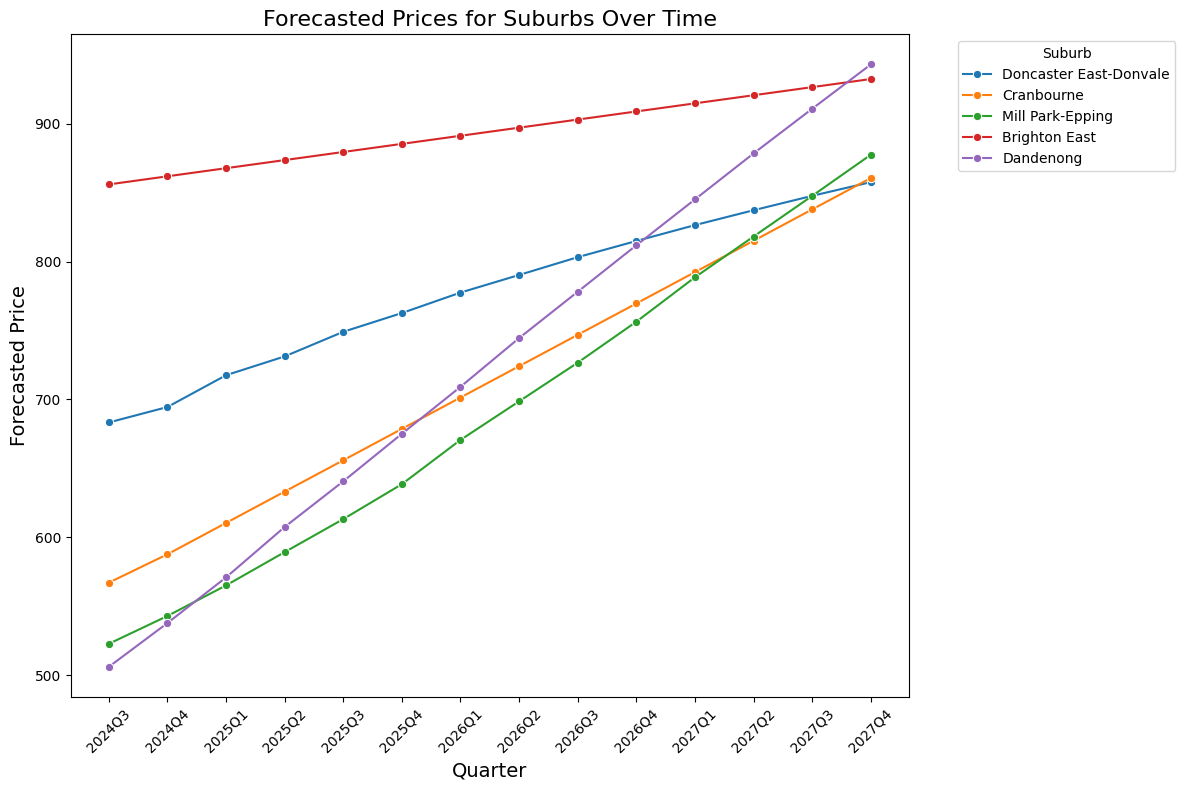

In [30]:
df_long = final_arima_df.sort_values("2027Q4").tail().melt(id_vars="Suburb", var_name="Quarter", value_name="Forecasted Price")

# Ensure quarters are sorted correctly
df_long["Quarter"] = pd.Categorical(df_long["Quarter"], categories=final_arima_df.columns[1:], ordered=True)
df_long = df_long.sort_values(by="Quarter")

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_long, x="Quarter", y="Forecasted Price", hue="Suburb", marker="o")

# Customize the plot
plt.title("Forecasted Prices for Suburbs Over Time", fontsize=16)
plt.xlabel("Quarter", fontsize=14)
plt.ylabel("Forecasted Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Suburb", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
final_arima_df.to_csv("../data/curated/future_predict_quarterly.csv", index=False)